# 6: Backtesting

## Imports & Settings

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


In [2]:
N_LONGS = 5

## Load Data

### ML Predictions

In [3]:
DATA_STORE = '../data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices'].sort_index()['close'].loc[pd.IndexSlice['2000':'2024']]
prices.index.names = ['date', 'symbol']
prices

date        symbol  
2000-01-03  BBAR.BA         7.614178
            BHIP.BA         1.385000
            BMA.BA          2.180000
            BOLT.BA         0.017411
            CAPX.BA         1.393596
                            ...     
2024-01-02  TGSU2.BA     3045.300049
            TRAN.BA      1234.000000
            TXAR.BA       825.000000
            VALO.BA       223.500000
            YPFD.BA     16530.650391
Name: close, Length: 299259, dtype: float64

In [4]:
predictions = pd.concat([pd.read_hdf('../data/predictions.h5', 'lgb/train/01'), pd.read_hdf('../data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)])
predictions = (predictions.loc[~predictions.index.duplicated()]
				.iloc[:, :10]
				.mean(1)
				.sort_index()
				.dropna()
				.to_frame('prediction'))
tickers = predictions.index.get_level_values('symbol').unique().tolist()

In [5]:
predictions = predictions.join(prices)
predictions

prediction        close
symbol  date                               
ALUA.BA 2020-12-03    0.009860    52.200001
        2020-12-04    0.014928    52.200001
        2020-12-09    0.008148    48.950001
        2020-12-10    0.018542    50.099998
        2020-12-11    0.027393    49.450001
...                        ...          ...
YPFD.BA 2022-12-26   -0.006042  3084.949951
        2022-12-27   -0.009006  3003.800049
        2022-12-28   -0.003205  3130.000000
        2022-12-29   -0.012606  3111.500000
        2022-12-30   -0.009665  3168.449951

[31109 rows x 2 columns]

## Custom backtesting

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = predictions

def backtest(df, initial_capital=1):
	portfolio_value = []
	open_positions = dict()
	positions = []
	value = initial_capital

	dates = df.index.levels[1]
	for date in dates:
		daily_df = df.xs(date, level='date')

		# use open open_positions to compute total value
		if len(open_positions) > 0:
			value = 0
			for (ticker, alloc) in open_positions.items():
				if ticker == 'cash':
					value += alloc
				else:
					price = daily_df.loc[ticker, 'close']
					value += price * alloc
		portfolio_value.append(value)

		# select next 5 best predictions
		top_predictions = daily_df[daily_df['prediction'] > 0].nlargest(N_LONGS, 'prediction')

		open_positions = dict()

		if len(top_predictions) == 0:
			open_positions['cash'] = value
		else:
			# update open open_positions
			allocation = value / len(top_predictions)
			for ticker in top_predictions.index:
				price = daily_df.loc[ticker, 'close']
				open_positions[ticker] = allocation / price
			
		positions.append(open_positions)

	return portfolio_value, positions

portfolio_value, positions = backtest(df)

portfolio_df = pd.DataFrame({
    'date': df.index.levels[1],
    'portfolio_value': portfolio_value,
	'positions': positions
})
portfolio_df

,date,portfolio_value,positions
0,2020-12-03,1.000000,"{'IRSA.BA': 0.0026355708768131215, 'OEST.BA': ..."
1,2020-12-04,0.997674,"{'LONG.BA': 0.03320045762144735, 'CRES.BA': 0...."
2,2020-12-09,0.964029,"{'GRIM.BA': 0.007140955322325848, 'IRSA.BA': 0..."
3,2020-12-10,0.974099,"{'LEDE.BA': 0.0065048354616359634, 'ROSE.BA': ..."
4,2020-12-11,0.981612,"{'LEDE.BA': 0.006599074333410735, 'ALUA.BA': 0..."
...,...,...,...
741,2023-12-21,1430.504964,"{'ALUA.BA': 0.3014762832146999, 'BBAR.BA': 0.1..."
742,2023-12-22,1445.296966,"{'ALUA.BA': 0.3070200670890049, 'COME.BA': 3.9..."
743,2023-12-26,1402.616963,"{'DYCA.BA': 0.7846808185423443, 'MIRG.BA': 0.0..."
744,2023-12-27,1365.862712,"{'MIRG.BA': 0.026747531821603648, 'ALUA.BA': 0..."


In [7]:
df_expanded = portfolio_df['positions'].apply(pd.Series).fillna(0)
positions_df = pd.concat([portfolio_df['date'], df_expanded], axis=1)
positions_df['date'] = pd.to_datetime(positions_df['date'])
positions_df = positions_df.set_index(['date']).tz_localize('UTC')

Graficar resultados

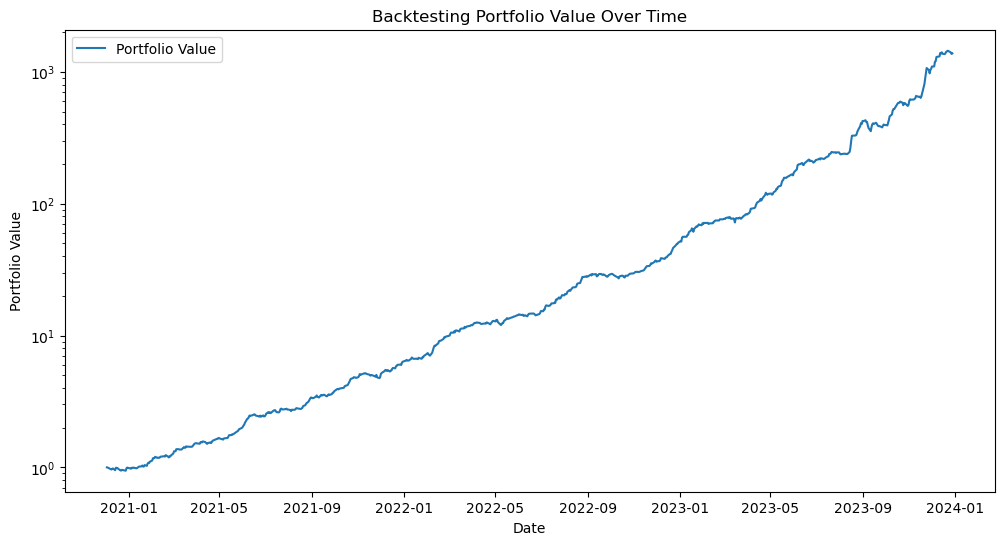

In [8]:
# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.yscale('log')
plt.title('Backtesting Portfolio Value Over Time')
plt.legend()
plt.show()


In [10]:
sp_merval = pd.read_csv('../data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'close'}).set_index(['date'])['close']

In [11]:
portfolio_df = portfolio_df.set_index(['date'])

In [12]:
sp_merval.reindex(portfolio_df.index)

date
2020-12-03   NaN
2020-12-04   NaN
2020-12-09   NaN
2020-12-10   NaN
2020-12-11   NaN
              ..
2023-12-21   NaN
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
Name: close, Length: 746, dtype: float64

In [14]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['open', 'close', 'low', 'high', 'volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['merval/prices'][ohlcv])


## Metrics in USD

Get dolar "BOLSA" price

In [18]:
import requests
from datetime import timedelta, datetime

# Función para obtener los tipos de cambio de dolarhoy.com
def get_exchange_rate_history():
    url = "https://api.argentinadatos.com/v1/cotizaciones/dolares"  # Endpoint hipotético, cambia según el correcto
    response = requests.get(url)
    data = response.json()

    # Filtrar los datos para incluir solo aquellos con casa: "blue"
    exchange_rates = [
        {'date': item['fecha'], 'exchange_rate': item['venta']}
        for item in data
        if item['casa'] == 'bolsa'
    ]

    # Convertir a DataFrame
    df_exchange_rates = pd.DataFrame(exchange_rates)
    
    # Convertir la columna 'date' a datetime
    df_exchange_rates['date'] = pd.to_datetime(df_exchange_rates['date'], format='%Y-%m-%d')
    
    return df_exchange_rates

exchange_rates = get_exchange_rate_history()

In [19]:
exchange_rates = exchange_rates.set_index('date')

In [20]:
exchange_rates = exchange_rates.reindex(portfolio_df.index)
exchange_rates

,exchange_rate
date,
2020-12-03,139.74
2020-12-04,142.05
2020-12-09,139.49
2020-12-10,138.22
2020-12-11,138.22
...,...
2023-12-21,971.13
2023-12-22,956.13
2023-12-26,945.02


In [21]:
a = portfolio_df['portfolio_value'] / exchange_rates['exchange_rate']
portfolio_df['portfolio_value'] = a / a[0]
portfolio_df

,portfolio_value,positions
date,,
2020-12-03,1.000000,"{'IRSA.BA': 0.0026355708768131215, 'OEST.BA': ..."
2020-12-04,0.981450,"{'LONG.BA': 0.03320045762144735, 'CRES.BA': 0...."
2020-12-09,0.965757,"{'GRIM.BA': 0.007140955322325848, 'IRSA.BA': 0..."
2020-12-10,0.984811,"{'LEDE.BA': 0.0065048354616359634, 'ROSE.BA': ..."
2020-12-11,0.992407,"{'LEDE.BA': 0.006599074333410735, 'ALUA.BA': 0..."
...,...,...
2023-12-21,205.841405,"{'ALUA.BA': 0.3014762832146999, 'BBAR.BA': 0.1..."
2023-12-22,211.232571,"{'ALUA.BA': 0.3070200670890049, 'COME.BA': 3.9..."
2023-12-26,207.404811,"{'DYCA.BA': 0.7846808185423443, 'MIRG.BA': 0.0..."


## PyFolio Analysis

In [22]:
returns = portfolio_df['portfolio_value'].pct_change().tz_localize('UTC')

In [23]:
sp_merval = pd.read_csv('../data/merval.csv')
sp_merval = sp_merval[['Date','Adj Close']].rename(columns={'Date':'date', 'Adj Close':'MERVAL'})
sp_merval['date'] = pd.to_datetime(sp_merval['date'])
# LO DE ARRIBA ES PARA CARGAR EL INDICE MERVAL, LO DE ABAJO PARA USAR EL INDICE PROPIO (rinden casi igual)
# sp_merval = index_df
# sp_merval = index_gral_df

In [24]:
sp_merval = sp_merval.set_index(['date'])
sp_merval = sp_merval.reindex(portfolio_df['portfolio_value'].index)

# Express results in USD
sp_merval['MERVAL'] = sp_merval['MERVAL'] / exchange_rates['exchange_rate']


In [25]:
benchmark = sp_merval['MERVAL'].pct_change().tz_localize('UTC')
benchmark = benchmark.reindex(returns.index)

In [26]:
import yfinance as yf

start_date = '2020-01-01'
end_date = '2024-01-01'
sp500_values = yf.download('SPY', start=start_date, end=end_date)['Adj Close']
sp500_values

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    303.135651
2020-01-03    300.840149
2020-01-06    301.987915
2020-01-07    301.138794
2020-01-08    302.743713
                 ...    
2023-12-22    470.664490
2023-12-26    472.651886
2023-12-27    473.506470
2023-12-28    473.685333
2023-12-29    472.314026
Name: Adj Close, Length: 1006, dtype: float64

In [27]:
sp500_benchmark = sp500_values.pct_change().tz_localize('UTC').reindex(returns.index)

### Custom Plots

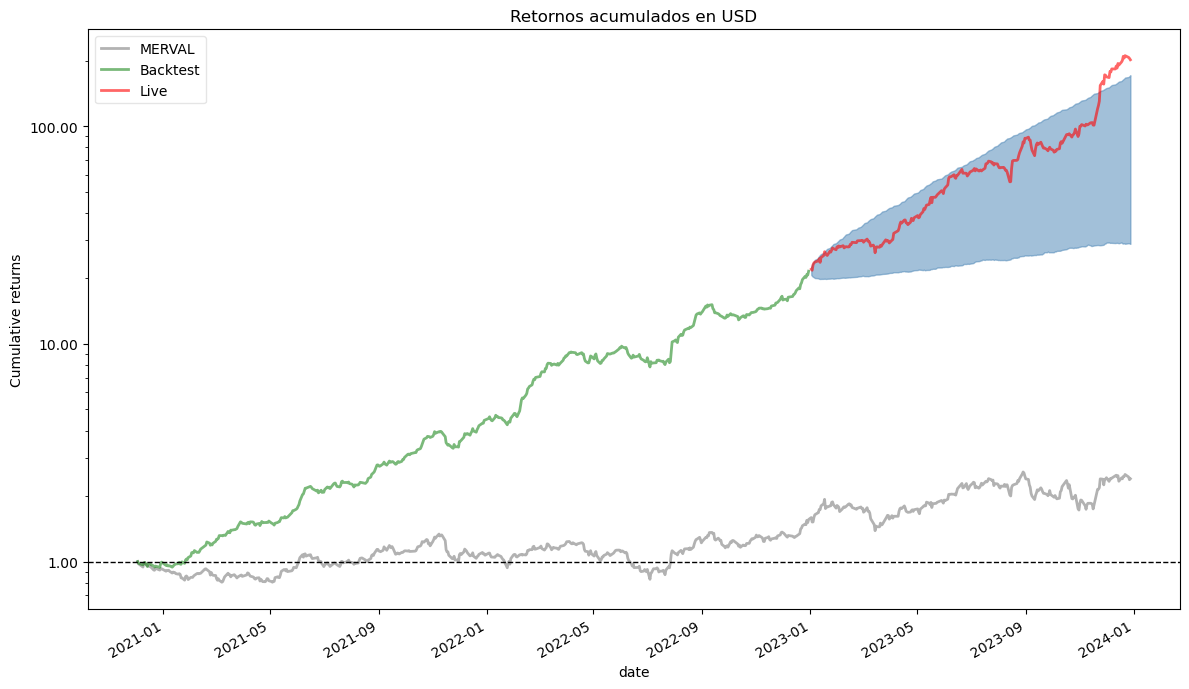

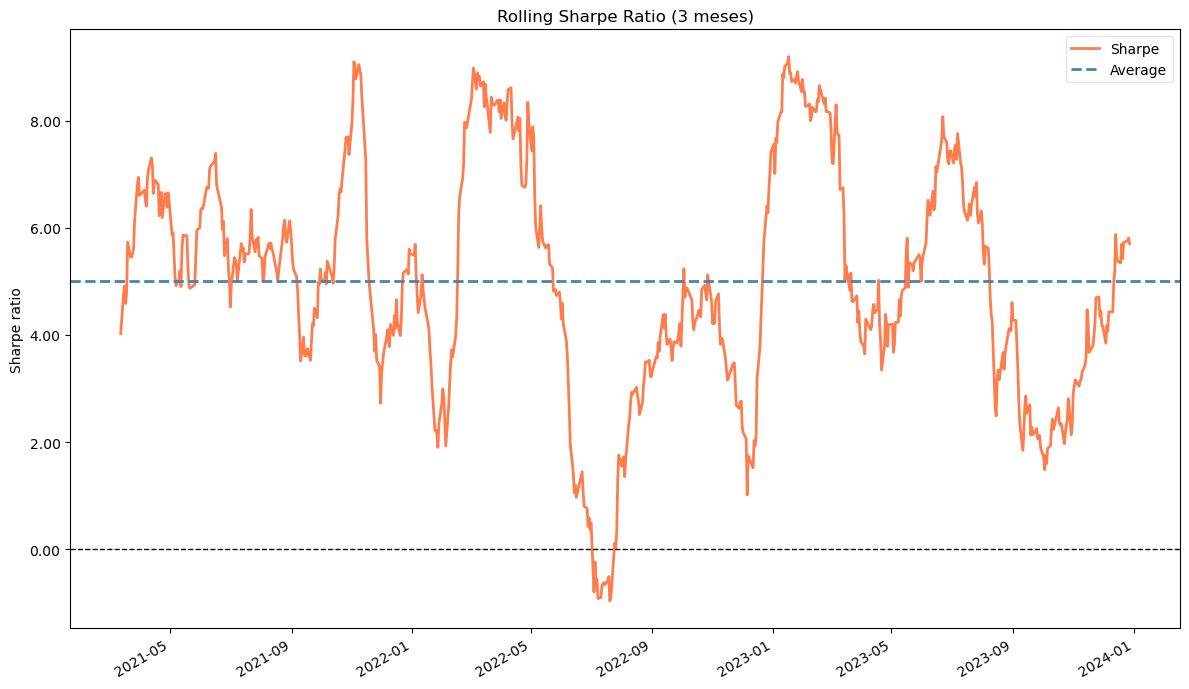

In [28]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
plot_rolling_returns(
    returns,
    factor_returns=benchmark,
    live_start_date='2023-01-01',
    logy=True,
    cone_std=2,
    legend_loc='best',
    volatility_match=False,
    cone_function=forecast_cone_bootstrap,
    ax=ax1
)
ax1.set_title('Retornos acumulados en USD')
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(12, 7))
plot_rolling_sharpe(returns, ax=ax2, rolling_window=63)
ax2.set_title('Rolling Sharpe Ratio (3 meses)')
fig2.tight_layout()

plt.show()


Compute anualized variation of merval:

In [29]:
first_row = sp_merval.iloc[0]
last_row = sp_merval.iloc[-1]
increase = (last_row['MERVAL'] / first_row['MERVAL'])
print(f'The MERVAL index grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The MERVAL index grew by x2.402796
Anualized is: %133.938555


In [30]:
first_row = portfolio_df.iloc[0]
last_row = portfolio_df.iloc[-1]
increase = (last_row['portfolio_value'] / first_row['portfolio_value'])
print(f'The PORTFOLIO grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The PORTFOLIO grew by x202.236636
Anualized is: %586.975459


In [31]:
first_row = sp500_values.iloc[0]
last_row = sp500_values.iloc[-1]
increase = (last_row / first_row)
print(f'The SP500 grew by x{increase:02f}')

anualized = 100* (increase**(1/3))
print(f'Anualized is: %{anualized:02f}')


The SP500 grew by x1.558095
Anualized is: %115.930562


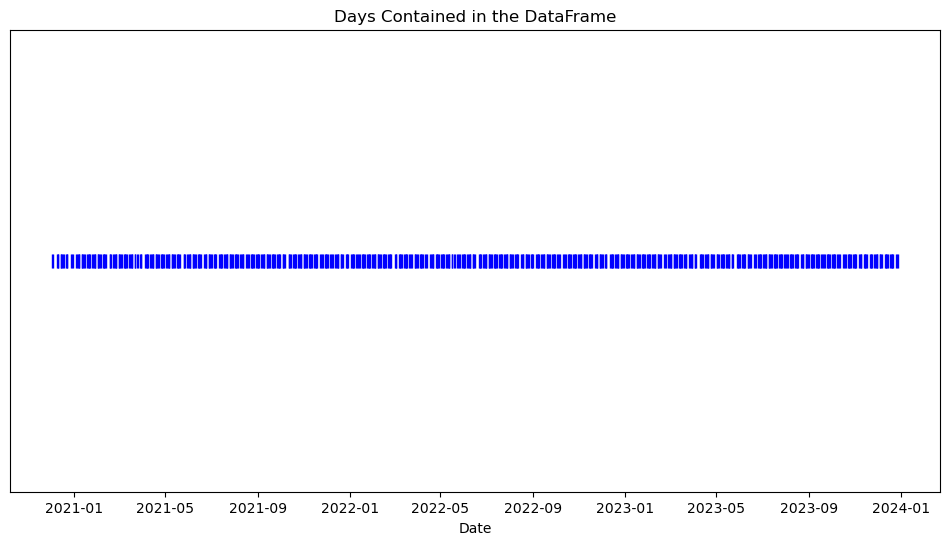

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo de creación de DataFrame
dates = portfolio_df.index
portfolio_values = portfolio_df['portfolio_value']
df = pd.DataFrame({'portfolio_value': portfolio_values}, index=dates)

# Crear una serie de datos indicando los días contenidos en el DataFrame
days_in_df = df.index

# Graficar los días contenidos en el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(days_in_df, [1]*len(days_in_df), '|', color='blue', markersize=10)  # Use pipe marker to indicate dates
plt.xlabel('Date')
plt.title('Days Contained in the DataFrame')
plt.yticks([])  # Remove y-axis ticks since we only care about the dates
plt.show()


### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.75,2022-06-02,2022-07-04,2022-07-29,42
1,19.71,2023-07-21,2023-08-14,2023-08-17,20
2,17.76,2023-09-04,2023-09-11,2023-10-17,32
3,16.41,2021-11-10,2021-11-24,2021-12-16,27
4,14.88,2022-09-12,2022-10-12,2022-11-23,53


/Users/tomas/miniforge3/envs/ml4t/lib/python3.8/site-packages/pyfolio/plotting.py:1407: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.75%,-9.78%,18.97%


Top 10 long positions of all time,max
LONG.BA,100.00%
CECO2.BA,100.00%
POLL.BA,100.00%
GARO.BA,100.00%
DOME.BA,100.00%
CARC.BA,100.00%
MOLI.BA,100.00%
CTIO.BA,100.00%
INVJ.BA,96.86%
BOLT.BA,94.07%


Top 10 short positions of all time,max


Top 10 positions of all time,max
LONG.BA,100.00%
CECO2.BA,100.00%
POLL.BA,100.00%
GARO.BA,100.00%
DOME.BA,100.00%
CARC.BA,100.00%
MOLI.BA,100.00%
CTIO.BA,100.00%
INVJ.BA,96.86%
BOLT.BA,94.07%


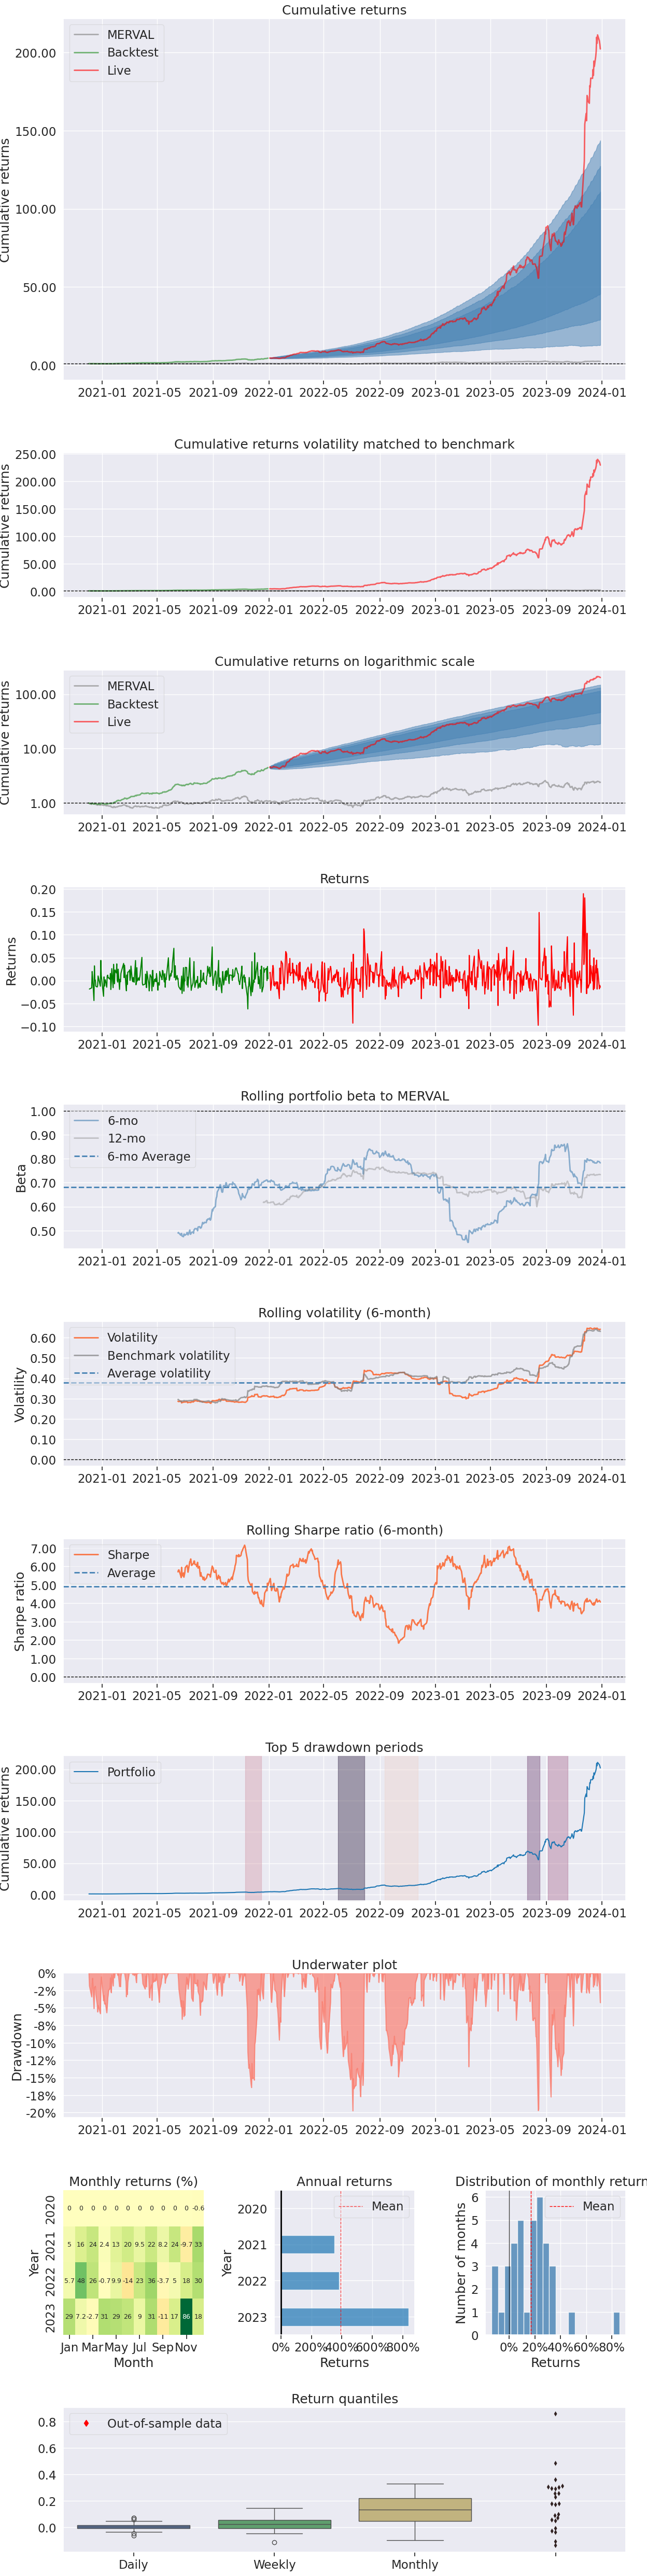

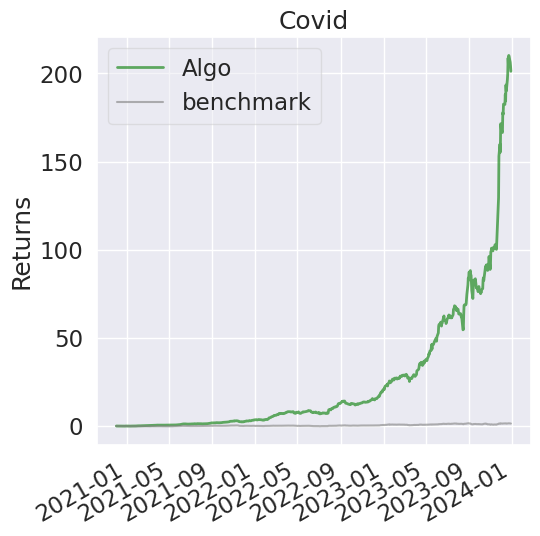

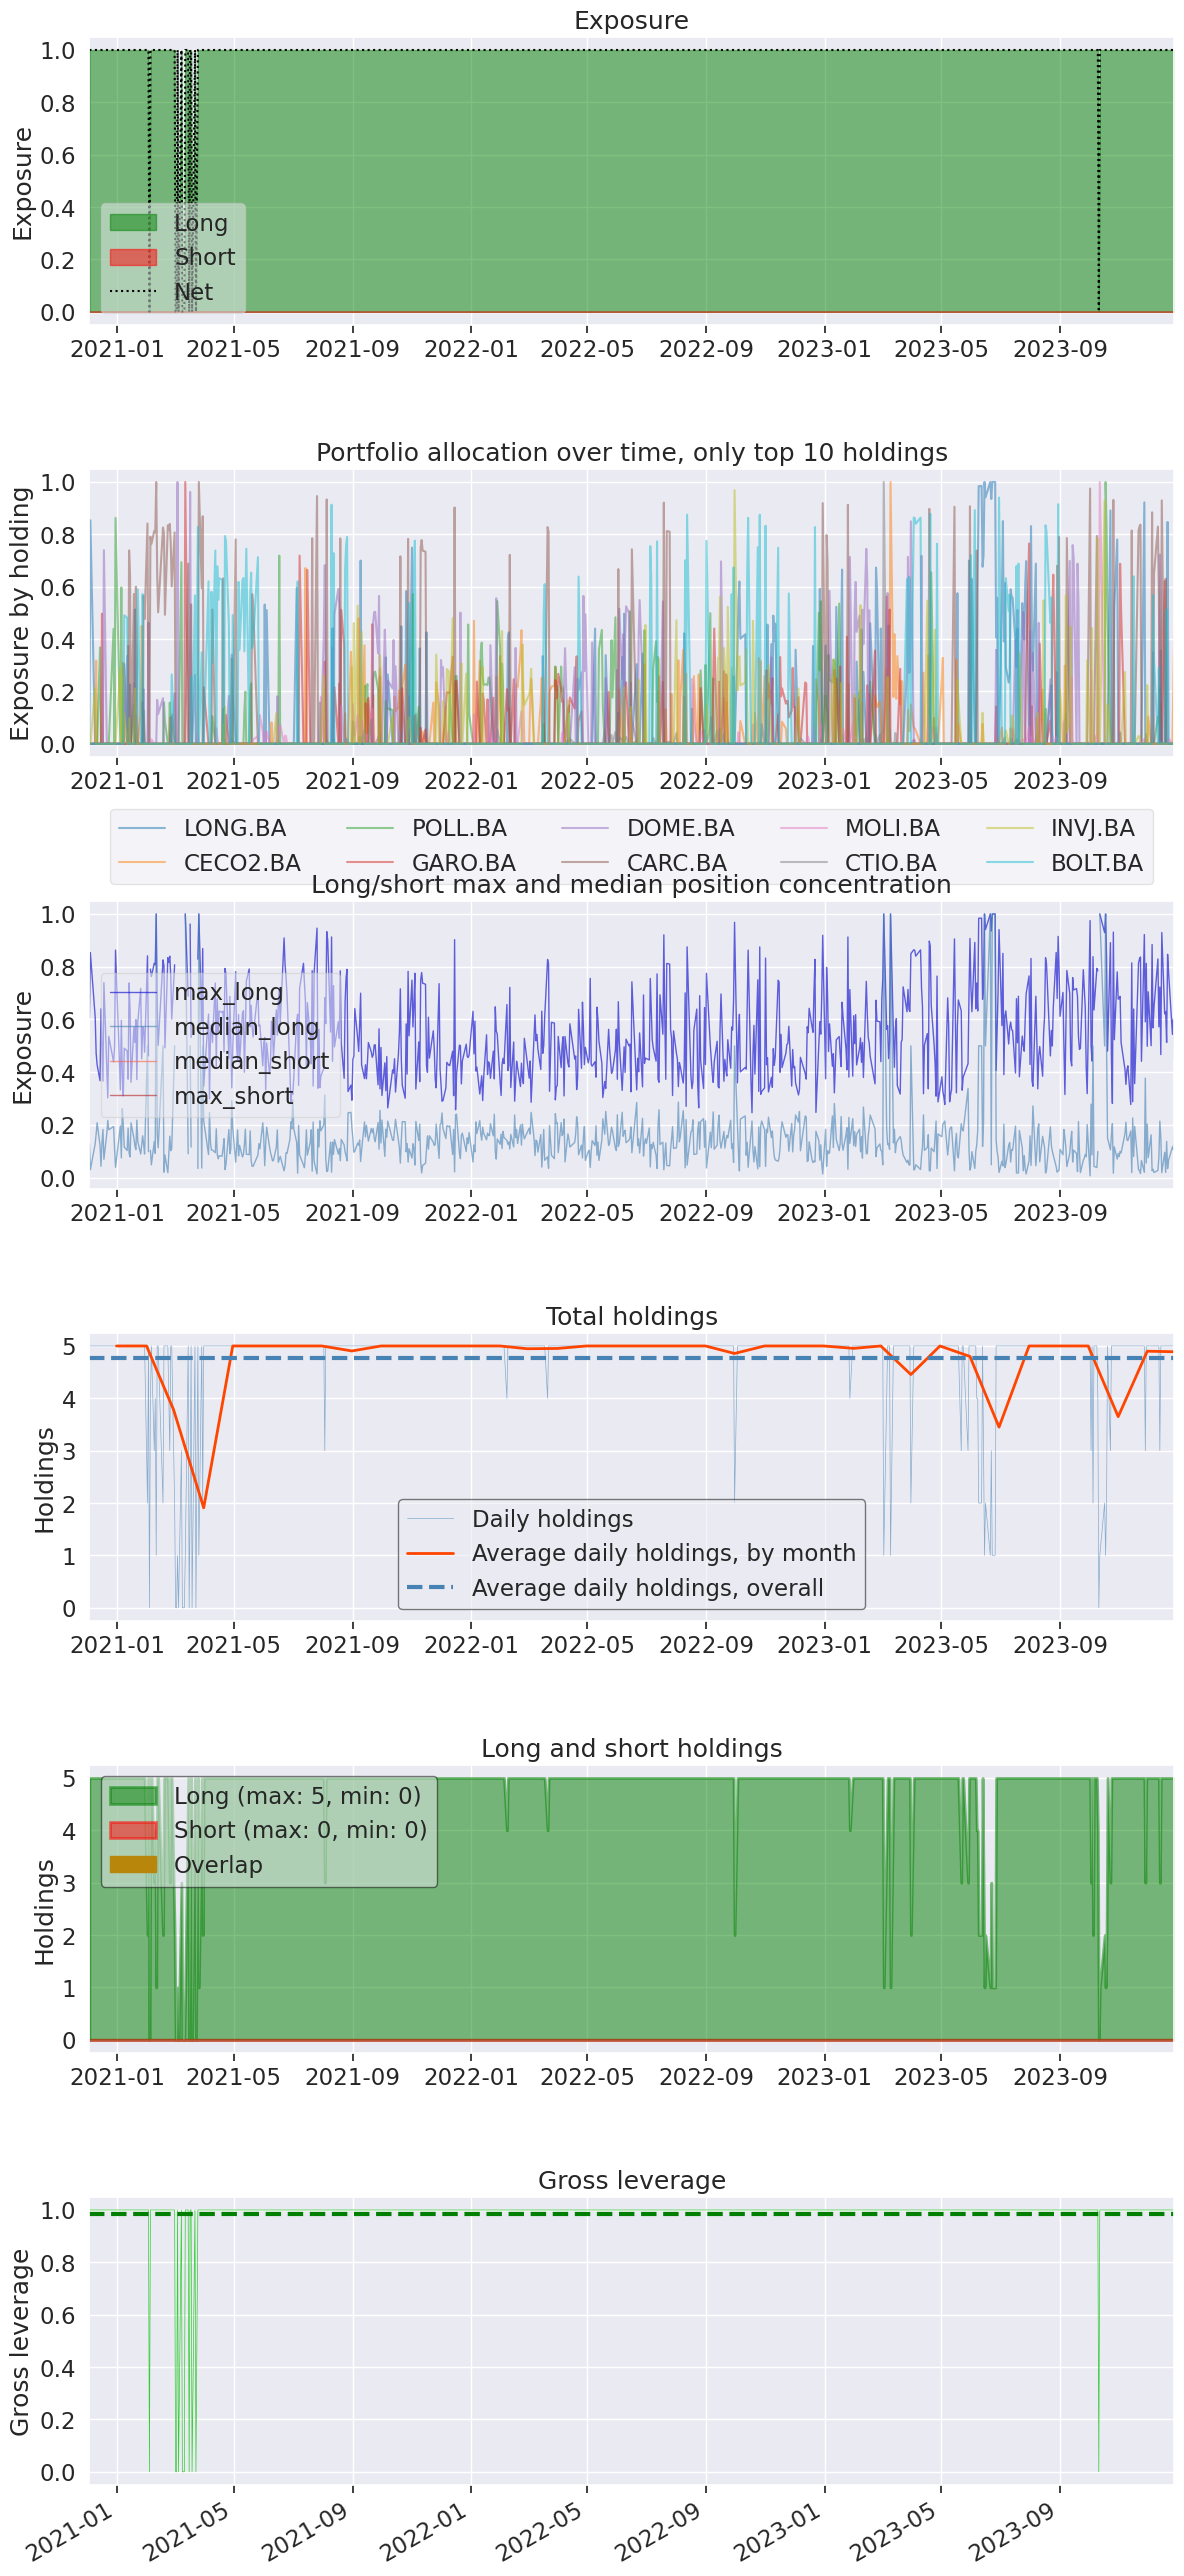

In [33]:
pf.create_full_tear_sheet(returns, 
                          positions=positions_df, 
                          transactions=None,
                          benchmark_rets=benchmark,
                          live_start_date='2022-01-01', 
                          round_trips=True)